<a href="https://colab.research.google.com/github/rajatc2/Machine-Learning/blob/main/Next-Day-Temperature/Temperature_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Load and Baseline Prediction

In [ ]:
import numpy as np
from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
  drive.mount('/content/drive')
  datadir = "/content/drive/My Drive/CS441/hw1/"
  T = np.load(datadir + 'temperature_data.npz')
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target temperature
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()

Mounted at /content/drive
Feature 361: city = Cleveland, day= -1
Baseline - predict same as previous day: RMSE=3.460601246750482, MAE=1.3964240043768943


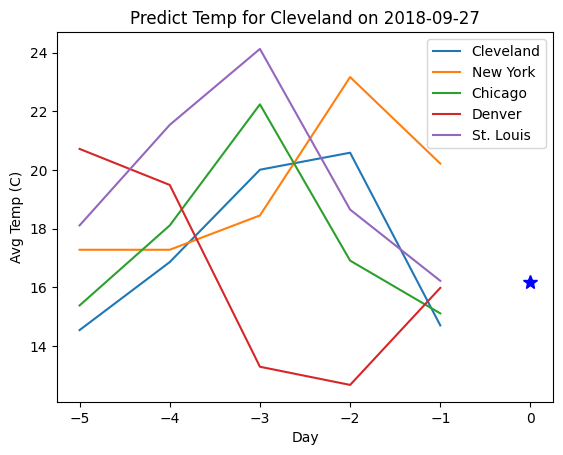

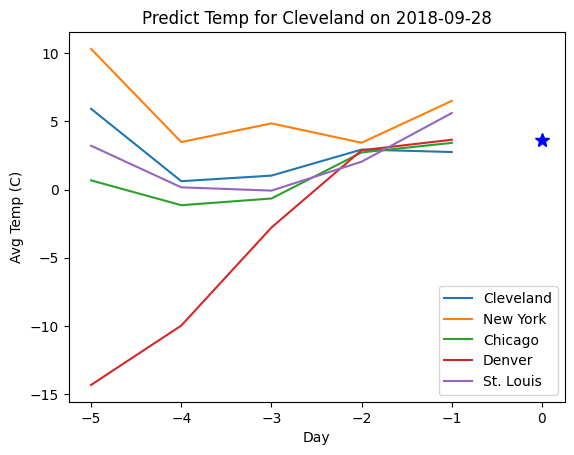

In [ ]:
# load data (may need to modify file location in preceding cell)
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()

# example of displaying information related to a feature index
f = 361
print('Feature {}: city = {}, day= {}'.format(f,feature_to_city[f], feature_to_day[f]))

# example of computing RMSE and median absolute error (for baseline of predicting based on previous day's temperature in Cleveland)
baseline_rmse = np.sqrt(np.mean((y_val[1:]-y_val[:-1])**2)) # root mean squared error
baseline_mae = np.sqrt(np.median(np.abs(y_val[1:]-y_val[:-1]))) # median absolute error
print('Baseline - predict same as previous day: RMSE={}, MAE={}'.format(baseline_rmse, baseline_mae))

# plots temperatures for preceding days for given cities, and target (Cleveland) temp
plot_temps(x_val[0], y_val[0], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[0])
plot_temps(x_val[100], y_val[100], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[1])

# 1. Implement and test KNN, Naive Bayes (NB), and Linear Regression (LR)

## 1a. KNN

In [ ]:
# This is a suggested function definition for KNN, but feel free to change it
def classify_KNN_temp(X_trn, y_trn, X_tst, K=1):
  '''
  Classify each data point in X_tst using a K-nearest neighbor classifier based on (X_trn, y_trn), with L2 distance.
  Input: X_trn[i] is the ith training data. y_trn[i] is the ith training label. K is the number of closest neighbors to use.
  Output: return y_pred, where y_pred[i] is the predicted ith test label
  '''
  # needs code
  y_pred=[]
  for i in range(len(X_tst)):
    dist=np.sum((X_trn-X_tst[i])**2, axis=1)
    kin=np.argsort(dist)[:K]
    #print(kin.shape)
    #print(y_train[kin])
    #print(stat.mode(y_train[kin]))
    y_pred.append(np.mean(y_trn[kin]))
  return y_pred

In [ ]:
# On Validation Set

y_pred_temp=classify_KNN_temp(x_train, y_train, x_val, 3)
knn_rmse = np.sqrt(np.mean((y_val-y_pred_temp)**2)) # root mean squared error
knn_mae = np.sqrt(np.median(np.abs(y_val-y_pred_temp))) # median absolute error
print("Validation RMSE:", knn_rmse)
print("Validation MAE:", knn_mae)

# On Test Set

y_pred_temp=classify_KNN_temp(x_train, y_train, x_test, 3)
knn_rmse = np.sqrt(np.mean((y_test-y_pred_temp)**2)) # root mean squared error
knn_mae = np.sqrt(np.median(np.abs(y_test-y_pred_temp))) # median absolute error
print("Test RMSE:", knn_rmse)
print("Test MAE:", knn_mae)

Validation RMSE: 3.2266843182278797
Validation MAE: 1.4433756729740643
Test RMSE: 3.4030752186343767
Test MAE: 1.5022205785658336


## 1b. Naive Bayes

In [ ]:
# Suggested function definition for NB for temperature regression, but feel free to change
def train_NB_temp(X, y, std_prior=0):
  '''
  Train NB, assuming that X[f]-y is a Gaussian
  Input: X[i] is the ith training data. y[i] is the ith training label. std_prior is a value to add to std
  Output: return pxy['mu'] and pxy['std'] each with number of values equal to number of features
  '''
  # needs code
  pxy=dict()
  n_feat=X.shape[1]
  mu = np.zeros((n_feat))
  std = np.zeros((n_feat))
  for i in range(n_feat):
    std[i] = np.std(y-X[:,i], axis=0)+np.sqrt(std_prior/len(X))
    mu[i] = np.mean(y-X[:,i], axis=0)
  #return mu, std
  pxy['mu']=mu
  pxy['std']=std
  return pxy

def eval_NB_temp(pxy, X):
  '''
  Evaluate naive bayes for temp
  Input: pxy is the trained model; X is the test data
  Output: return y_pred, where y_pred[i] is the predicted ith test value
  '''
  # needs code
  mu=pxy.get('mu')
  std=pxy.get('std')
  pred_y=[]
  w=1/(std**2)
  for i in range(X.shape[0]):
    pred_y.append((1/np.sum(w))*(np.sum((X[i,:]+mu)*w)))

  return pred_y

In [ ]:
# On Validation set

p=train_NB_temp(x_train, y_train, std_prior=0)
y_pred_temp=eval_NB_temp(p, x_val)

NB_rmse = np.sqrt(np.mean((y_val-y_pred_temp)**2)) # root mean squared error
NB_mae = np.sqrt(np.median(np.abs(y_val-y_pred_temp))) # median absolute error
print("Validation RMSE:", NB_rmse)
print("Validation MAE:", NB_mae)

# On Test set

y_pred_test=eval_NB_temp(p, x_test)

NB_rmse = np.sqrt(np.mean((y_test-y_pred_test)**2)) # root mean squared error
NB_mae = np.sqrt(np.median(np.abs(y_test-y_pred_test))) # median absolute error
print("Test RMSE:", NB_rmse)
print("Test MAE:", NB_mae)

Validation RMSE: 3.784987716337962
Validation MAE: 1.5694926753644804
Test RMSE: 3.6458632686489647
Test MAE: 1.5485841565558451


## 1c. Linear Regression

In [ ]:
clft = Ridge().fit(x_train, y_train)

# On Validation Set
y_lr_val=clft.predict(x_val)
clft_rmse = np.sqrt(np.mean((y_lr_val-y_val)**2)) # root mean squared error
clft_mae = np.sqrt(np.median(np.abs(y_lr_val-y_val))) # median absolute error
print("Validation RMSE:", clft_rmse)
print("Validation MAE:", clft_mae)

# On Test Set
y_lr_test=clft.predict(x_test)
clft_rmse = np.sqrt(np.mean((y_lr_test-y_val)**2)) # root mean squared error
clft_mae = np.sqrt(np.median(np.abs(y_lr_test-y_val))) # median absolute error
print("Test RMSE:", clft_rmse)
print("Test MAE:", clft_mae)

Validation RMSE: 2.4382370170692576
Validation MAE: 1.2774635443414848
Test RMSE: 5.216780371762811
Test MAE: 1.7623658714015629


## 1d. Most Important Features

In [ ]:
# Feature analysis
clf_feat = Lasso().fit(x_train, y_train)
#print(clf_feat.coef_)
print(clf_feat.coef_.shape)
ind = np.flip(np.argsort(np.abs(clf_feat.coef_)))[:10]
print("Index with top 10 coefficients:",ind)
feature_to_city[ind], feature_to_day[ind]
print("Number of coefficients greater than 0.001 : ")
np.sum(np.where(np.abs(clf_feat.coef_)>0.001,1,0))

(415,)
Index with top 10 coefficients: [334 347 405 366 361 307 367 264   9 236]
Number of coefficients greater than 0.001 : 


13

In [ ]:
x_train_top=x_train[:,ind]
x_val_top=x_val[:,ind]
x_test_top=x_test[:,ind]
#y_train_top=y_train[ind]
print(x_train.shape)
print(x_train_top.shape)

(1825, 415)
(1825, 10)


KNN

In [ ]:
# On Validation Set

y_pred_temp=classify_KNN_temp(x_train_top, y_train, x_val_top, 3)
knn_rmse = np.sqrt(np.mean((y_val-y_pred_temp)**2)) # root mean squared error
knn_mae = np.sqrt(np.median(np.abs(y_val-y_pred_temp))) # median absolute error
print("Validation RMSE:", knn_rmse)
print("Validation MAE:", knn_mae)

# On Test Set

y_pred_temp=classify_KNN_temp(x_train_top, y_train, x_test_top, 3)
knn_rmse = np.sqrt(np.mean((y_test-y_pred_temp)**2)) # root mean squared error
knn_mae = np.sqrt(np.median(np.abs(y_test-y_pred_temp))) # median absolute error
print("Test RMSE:", knn_rmse)
print("Test MAE:", knn_mae)

Validation RMSE: 2.8231963490998595
Validation MAE: 1.2516655570345725
Test RMSE: 2.5032051113578686
Test MAE: 1.264911064067352


Naive Bayes

In [ ]:
# On Validation set

p=train_NB_temp(x_train_top, y_train, std_prior=0)
y_pred_temp=eval_NB_temp(p, x_val_top)

NB_rmse = np.sqrt(np.mean((y_val-y_pred_temp)**2)) # root mean squared error
NB_mae = np.sqrt(np.median(np.abs(y_val-y_pred_temp))) # median absolute error
print("Validation RMSE:", NB_rmse)
print("Validation MAE:", NB_mae)

# On Test set

y_pred_test=eval_NB_temp(p, x_test_top)

NB_rmse = np.sqrt(np.mean((y_test-y_pred_test)**2)) # root mean squared error
NB_mae = np.sqrt(np.median(np.abs(y_test-y_pred_test))) # median absolute error
print("Test RMSE:", NB_rmse)
print("Test MAE:", NB_mae)

Validation RMSE: 2.789998187480326
Validation MAE: 1.2292929124214962
Test RMSE: 2.663091482207028
Test MAE: 1.2546388126658221


Linear Regression

In [ ]:
clft = Ridge().fit(x_train_top, y_train)

# On Validation Set
y_lr_val=clft.predict(x_val_top)
clft_rmse = np.sqrt(np.mean((y_lr_val-y_val)**2)) # root mean squared error
clft_mae = np.sqrt(np.median(np.abs(y_lr_val-y_val))) # median absolute error
print("Validation RMSE:", clft_rmse)
print("Validation MAE:", clft_mae)

# On Test Set
y_lr_test=clft.predict(x_test_top)
clft_rmse = np.sqrt(np.mean((y_lr_test-y_val)**2)) # root mean squared error
clft_mae = np.sqrt(np.median(np.abs(y_lr_test-y_val))) # median absolute error
print("Test RMSE:", clft_rmse)
print("Test MAE:", clft_mae)

Validation RMSE: 2.261976344855625
Validation MAE: 1.1137065804262323
Test RMSE: 4.9104401932885615
Test MAE: 1.7358883149381559


## 1e. Improve Performance

Selecting Indexes with coefficient>0.001

In [ ]:
clf_feat = Lasso().fit(x_train, y_train)
#print(clf_feat.coef_)
#print(clf_feat.coef_.shape)
ind = np.flip(np.argsort(np.abs(clf_feat.coef_)))[:13]
print(ind)
print(np.abs(clf_feat.coef_[ind]))

[334 347 405 366 361 307 367 264   9 236 290 175 354]
[0.27959915 0.22594151 0.18013041 0.16295025 0.13835687 0.11124829
 0.04610279 0.04328024 0.02551791 0.02519758 0.01513985 0.00539925
 0.00178542]


In [ ]:
x_train_top=x_train[:,ind]
x_val_top=x_val[:,ind]
x_test_top=x_test[:,ind]

clft = Ridge().fit(x_train_top, y_train)
y=clft.predict(x_val_top)
clft_rmse = np.sqrt(np.mean((y-y_val)**2)) # root mean squared error
clft_mae = np.sqrt(np.median(np.abs(y-y_val))) # median absolute error
print("Validation RMSE:", clft_rmse)
print("Validation MAE:", clft_mae)

# On Test Set
y_lr_test=clft.predict(x_test_top)
clft_rmse = np.sqrt(np.mean((y_lr_test-y_val)**2)) # root mean squared error
clft_mae = np.sqrt(np.median(np.abs(y_lr_test-y_val))) # median absolute error
print("Test RMSE:", clft_rmse)
print("Test MAE:", clft_mae)

Validation RMSE: 2.256290048972406
Validation MAE: 1.1004994109040964
Test RMSE: 4.894867389036019
Test MAE: 1.7308749450057508


Introducing Feature Scaling

In [ ]:
def feature_scaling_train(X):
  # needs code
  n_feat=X.shape[1]
  mu=np.mean(X,axis=0)
  std=np.std(X,axis=0)
  #print(X.shape)
  #print(mu.shape)
  X_scaled=(X-mu)
  return X_scaled,mu,std

def feature_scaling_test(X,mu,std):
  X_scaled=(X-mu)
  return X_scaled

Augmentation of Data by adding noise

In [ ]:
noise = np.random.normal(0, 0.5, (x_train.shape))
x_train_augmented = x_train + noise;

noise = np.random.normal(0, 1, (x_train.shape))
x_train_augmented2 = x_train + noise;

#noise = np.random.normal(0, 0.8, (x_train.shape))
#x_train_augmented3 = x_train + noise;

x_train2 = np.concatenate((x_train, x_train_augmented, x_train_augmented2), axis=0)
y_train2 = np.concatenate((y_train, y_train, y_train))

Scaling and Important Features

In [ ]:
x_train_scaled,mu,std=feature_scaling_train(x_train2)
x_val_scaled=feature_scaling_test(x_val,mu,std)
x_test_scaled=feature_scaling_test(x_test,mu,std)

clf_feat = Lasso().fit(x_train_scaled, y_train2)
#print(clf_feat.coef_)
#print(clf_feat.coef_.shape)

no_ind=np.sum(np.where(np.abs(clf_feat.coef_)>0.001,1,0))
print("Number of coefficients greater than 0.001 : ", no_ind)

ind = np.flip(np.argsort(np.abs(clf_feat.coef_)))[:no_ind]

Number of coefficients greater than 0.001 :  14


Linear Regression

In [ ]:
clft = Ridge(alpha=52).fit(x_train_scaled[:,ind], y_train2)
y=clft.predict(x_val_scaled[:,ind])
clft_rmse = np.sqrt(np.mean((y-y_val)**2)) # root mean squared error
clft_mae = np.sqrt(np.median(np.abs(y-y_val))) # median absolute error
print("Validation RMSE:", clft_rmse)
#print("Validation MAE:", clft_mae)

y=clft.predict(x_test_scaled[:,ind])
clft_rmse = np.sqrt(np.mean((y-y_test)**2)) # root mean squared error
clft_mae = np.sqrt(np.median(np.abs(y-y_test))) # median absolute error
print("Test RMSE:", clft_rmse)
#print("Test MAE:", clft_mae)

Validation RMSE: 2.24868215632812
Test RMSE: 2.0467376280510425


# 2. Model Complexity of Tree Regressor

In [ ]:
# to plot the errors
def plot_depth_error(max_depths, tree_train_err, tree_val_err, rf_train_err, rf_val_err, bt_train_err, bt_val_err):
  plt.figure(figsize=(15,15))
  plt.semilogx(max_depths, tree_train_err, 'r.--',label='tree train')
  plt.semilogx(max_depths, tree_val_err, 'r.-', label='tree val')
  plt.semilogx(max_depths, rf_train_err, 'g.--',label='RF train')
  plt.semilogx(max_depths, rf_val_err, 'g.-', label='RF val')
  plt.semilogx(max_depths, bt_train_err, 'b.--',label='BT train')
  plt.semilogx(max_depths, bt_val_err, 'b.-', label='BT val')
  plt.ylabel('RMSE Error')
  plt.xlabel('Max Tree Depth')
  plt.xticks(max_depths, max_depths)
  plt.legend()
  plt.rcParams.update({'font.size': 20})
  plt.show()
  plt.savefig('error_vs_complexity.png', bbox_inches='tight')
  from google.colab import files
  files.download('error_vs_complexity.png')

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

max_depths = [2,4,8,16,32]
#print(x_train.shape, y_train.shape)
tree_train_err=np.zeros(len(max_depths))
tree_val_err=np.zeros(len(max_depths))
rf_train_err=np.zeros(len(max_depths))
rf_val_err=np.zeros(len(max_depths))
bt_train_err=np.zeros(len(max_depths))
bt_val_err=np.zeros(len(max_depths))

## 2a. Decision Tree

In [ ]:
#Decision Tree

for i in range(len(max_depths)):
  model = DecisionTreeRegressor(random_state=0, max_depth=max_depths[i])
  model.fit(x_train, y_train)
  y_pred=model.predict(x_val)
  tree_train_err[i]=np.sqrt(np.mean((y_train-model.predict(x_train))**2))
  tree_val_err[i]=np.sqrt(np.mean((y_val-model.predict(x_val))**2))

print(tree_train_err, '\n', tree_val_err)

[3.85377529 2.73936245 1.59050015 0.20196932 0.        ] 
 [4.18018688 2.78245508 3.16609855 3.53108794 3.57567467]


## 2b. Random Forest

In [ ]:
#Random Forest

for i in range(len(max_depths)):
  model = RandomForestRegressor(random_state=0, max_depth=max_depths[i], max_features=1/3)
  model.fit(x_train, y_train)
  rf_train_err[i]=np.sqrt(np.mean((y_train-model.predict(x_train))**2))
  rf_val_err[i]=np.sqrt(np.mean((y_val-model.predict(x_val))**2))

print(rf_train_err, '\n', rf_val_err)

[3.26711284 2.50811679 1.41487784 0.97338711 0.97724684] 
 [3.29220998 2.59839485 2.46333673 2.44363893 2.43624415]


## 2c. Gradient Boosting

In [32]:

#Gradient Boosting

for i in range(len(max_depths)):
  model = GradientBoostingRegressor(random_state=0, max_depth=max_depths[i])
  model.fit(x_train, y_train)
  bt_train_err[i]=np.sqrt(np.mean((y_train-model.predict(x_train))**2))
  bt_val_err[i]=np.sqrt(np.mean((y_val-model.predict(x_val))**2))

print(bt_train_err, '\n', bt_val_err)

[2.08437637e+00 1.26936587e+00 3.65942164e-02 2.81776009e-04
 2.81459183e-04] 
 [2.52100892 2.44558565 2.44222878 3.28859917 3.40171311]


[3.85377529 2.73936245 1.59050015 0.20196932 0.        ] 
 [4.18018688 2.78245508 3.16609855 3.53108794 3.57567467] 
 [3.26711284 2.50811679 1.41487784 0.97338711 0.97724684] 
 [3.29220998 2.59839485 2.46333673 2.44363893 2.43624415] 
 [2.08437637e+00 1.26936587e+00 3.65942164e-02 2.81776009e-04
 2.81459183e-04] 
 [2.52100892 2.44558565 2.44222878 3.28859917 3.40171311]


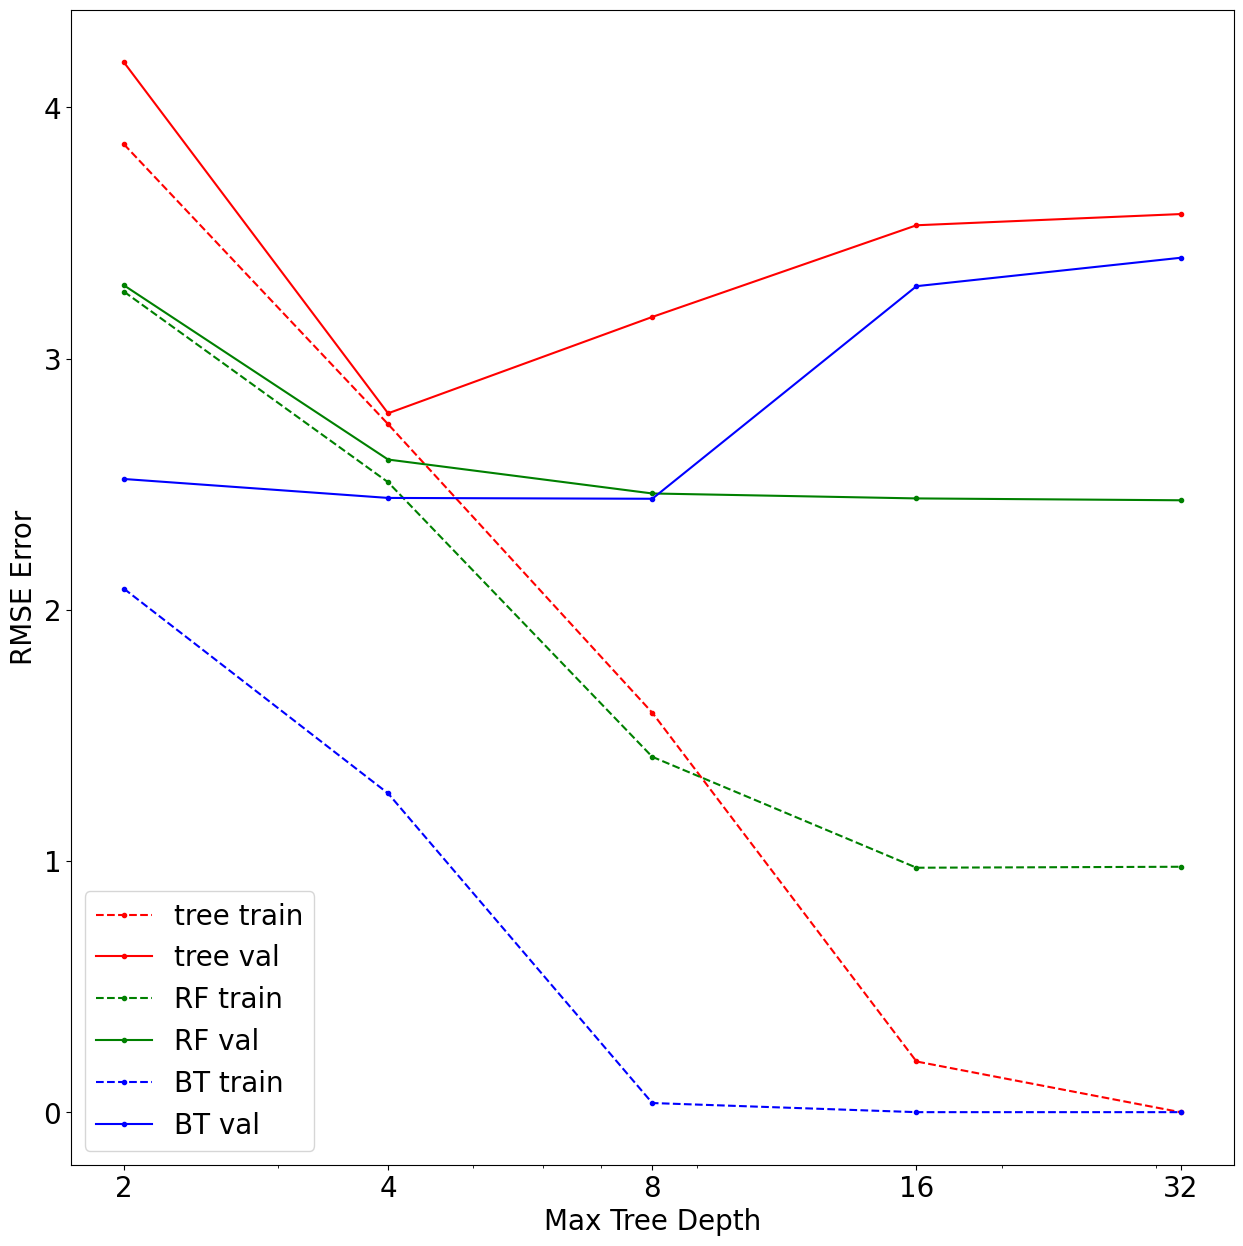

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [34]:
print(tree_train_err,'\n', tree_val_err,'\n', rf_train_err,'\n', rf_val_err,'\n', bt_train_err,'\n', bt_val_err)
plot_depth_error(max_depths, tree_train_err, tree_val_err, rf_train_err, rf_val_err, bt_train_err, bt_val_err)